In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
stack = 'MD589'
dataFolderName = 'NoCoors_RandomFalseMatched'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [36]:
def fun_get_learning_data_path(what, stack, data_set, structure_name, method, ext=None):
    LERANING_ROOT_PATH = '/shared/blob_matching_atlas/training_weight'
    if what=='weight':
        fn = 'weight.bp'
    elif what=='learning_parameters':
        fn = 'learning_parameters.pkl'
    elif what=='maxSimDiff':
        fn = 'maxSimDiff.bp'
    else:   
        assert ext is not None, 'Please specify extension'
        fn = what + ext
    
    fp = os.path.join(LERANING_ROOT_PATH, stack, data_set, structure_name, method, fn)
    return fp
        
        

In [39]:
def load_training_weight(what, stack, data_set, structure_name, method, ext=None):
    fp = fun_get_learning_data_path(what, stack, data_set, structure_name, method, ext=None)
    print('Loading %s'%fp)
    if not os.path.isfile(fp):
        sys.stderr.write('Warnning: File does not exist in the shared folder. Try to download from s3...')
        try:
            download_from_s3(fp)
        except:
            sys.stderr.write('Loading file %s failed.'%fp)
    return load_data(fp)

In [23]:
# Annotation data:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [42]:
load_structure = '7N'
data_weight = {}
data_maxSimDiff = {}

for load_structure in structure_section_list.keys():
    try:
        data_weight[load_structure] = load_training_weight(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method='SGD')
        data_maxSimDiff[load_structure] = load_training_weight(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method='SGD')
    except:
        sys.stderr.write('Missing strucutre %s\n'%load_structure)

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCA/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCA/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNC/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNC/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/DC/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCo

Warnning: File does not exist in the shared folder. Try to download from s3...Missing strucutre Sp5C
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCP/SGD/weight.bp
rm -rf "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCP/SGD/weight.bp" && mkdir -p "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCP/SGD"
aws s3 cp "s3://mousebrainatlas-data/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCP/SGD/weight.bp" "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VCP/SGD/weight.bp"


Missing strucutre VCP
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/AP/SGD/weight.bp
rm -rf "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/AP/SGD/weight.bp" && mkdir -p "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/AP/SGD"
aws s3 cp "s3://mousebrainatlas-data/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/AP/SGD/weight.bp" "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/AP/SGD/weight.bp"


Missing strucutre AP
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/PBG/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/PBG/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/R/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/R/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LRt/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LRt/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IO/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IO/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LSO/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoo

Missing strucutre IC
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LPB/SGD/weight.bp
rm -rf "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LPB/SGD/weight.bp" && mkdir -p "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LPB/SGD"
aws s3 cp "s3://mousebrainatlas-data/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LPB/SGD/weight.bp" "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/LPB/SGD/weight.bp"


Missing strucutre LPB
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IF/SGD/weight.bp
rm -rf "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IF/SGD/weight.bp" && mkdir -p "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IF/SGD"
aws s3 cp "s3://mousebrainatlas-data/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IF/SGD/weight.bp" "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IF/SGD/weight.bp"


Missing strucutre IF
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VLL/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VLL/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IPA/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IPA/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/MPB/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/MPB/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Gr/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Gr/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/VTg/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/N

Missing strucutre SC
Warnning: File does not exist in the shared folder. Try to download from s3...

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNR/SGD/weight.bp
rm -rf "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNR/SGD/weight.bp" && mkdir -p "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNR/SGD"
aws s3 cp "s3://mousebrainatlas-data/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNR/SGD/weight.bp" "/shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNR/SGD/weight.bp"
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/MVe/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/MVe/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SuVe/SGD/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SuVe/SGD/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weigh

Missing strucutre SNR


In [41]:
load_training_weight(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name='Tz', method='SGD_9_26')

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD_9_26/maxSimDiff.bp


array([ 0.9621,  0.9653])

In [43]:
upload_to_s3('/shared/blob_matching_atlas',is_dir=True)

aws s3 cp --recursive "/shared/blob_matching_atlas" "s3://mousebrainatlas-data/blob_matching_atlas"


## Overall statistics of weights:

In [7]:
# Statistics of obtained weight for each structure:
structure_weight_mean = {}
structure_weight_std = {}
for structure_name in data_maxSimDiff.keys():
    structure_weight_mean[structure_name] = np.mean(data_weight[structure_name], axis=0).flatten()
    structure_weight_std[structure_name] = np.std(data_weight[structure_name], axis=0).flatten()
    

In [8]:
learning_features = ['area', 'eccentricity', 'compactness', 'moments_hu1','moments_hu2', 'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6', 'moments_hu7']

In [9]:
mean_feature_weight_for_each_structure = {}
for idx in range(len(learning_features)):
    feature_name = learning_features[idx]
    mean_feature_weight_for_each_structure[feature_name] = []
    for structure_name in structure_weight_mean.keys():
        mean_feature_weight_for_each_structure[feature_name].append(structure_weight_mean[structure_name][idx])

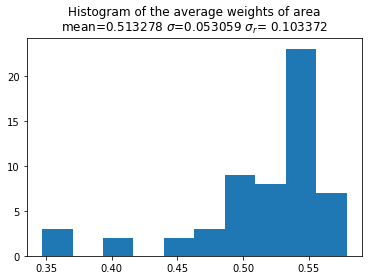

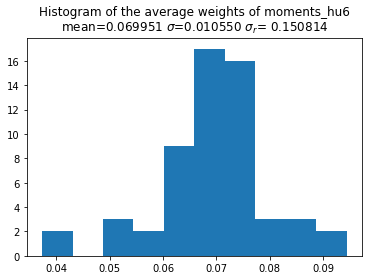

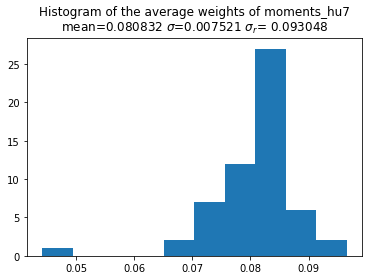

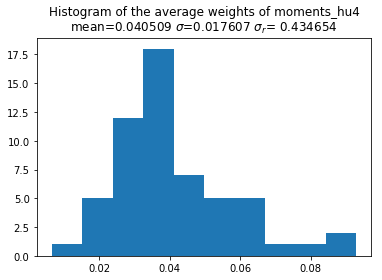

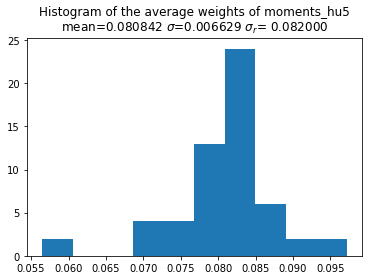

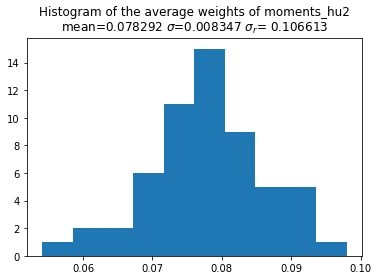

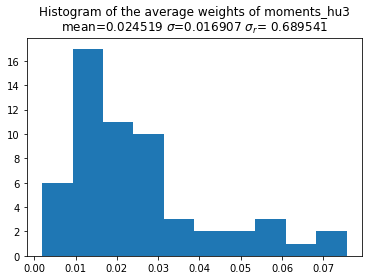

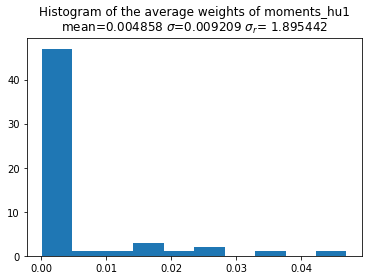

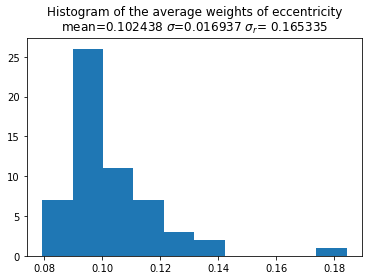

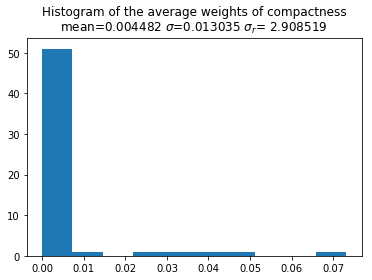

In [10]:
mean_feature_weight = {}
std_feature_weight = {}
for feature_name in mean_feature_weight_for_each_structure.keys():
    mean_feature_weight[feature_name] = np.mean(mean_feature_weight_for_each_structure[feature_name])
    std_feature_weight[feature_name] = np.std(mean_feature_weight_for_each_structure[feature_name])
    plt.figure()
    plt.hist(mean_feature_weight_for_each_structure[feature_name]);
    plt.title('Histogram of the average weights of %s\nmean=%f $\sigma$=%f $\sigma_r$= %f'%(feature_name, mean_feature_weight[feature_name], std_feature_weight[feature_name], std_feature_weight[feature_name]/mean_feature_weight[feature_name]))

1. Area is the most important feature for matching typical blobs against blobs randomly selected from the other area of the brain stem.
2. eccentricity, Hu moment 2,5,6,7 are useful features with average weights around 0.07 ~ 0.1
3. Compactness is useless in this case


## Best weight obtained for each structure

In [11]:
def fun_vector_distance_cos(vec1, vec2):
    vec1 = np.array(vec1.flatten(), dtype=np.float)
    vec2 = np.array(vec2.flatten(), dtype=np.float)
    cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_angle

In [12]:
tempOrder = np.argsort(data_maxSimDiff['7N'])[::-1]
tempVecDistance = []
for idx in tempOrder:
    tempVecDistance.append(fun_vector_distance_cos(data_weight['7N'][1677], data_weight['7N'][idx]))

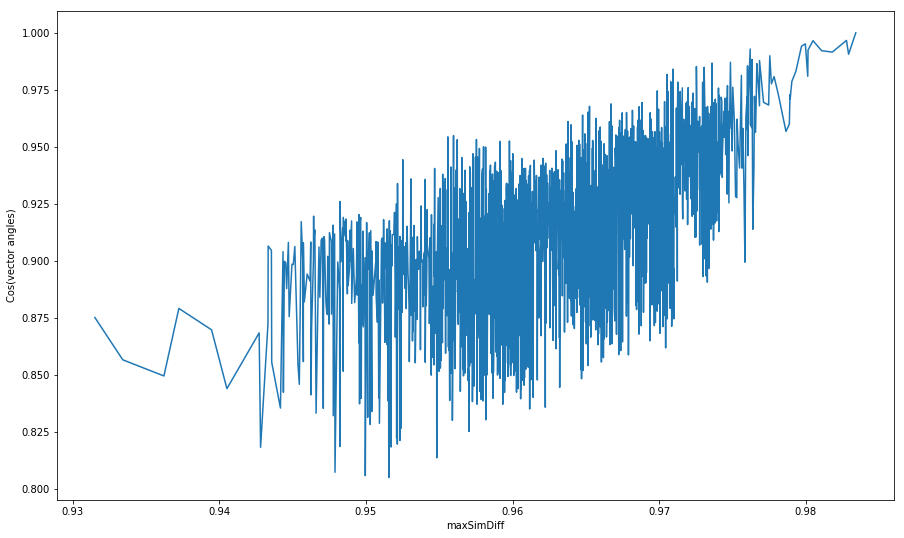

In [13]:
plt.figure(figsize=(15,9))
plt.plot(data_maxSimDiff['7N'][tempOrder], tempVecDistance)
plt.ylabel('Cos(vector angles)')
plt.xlabel('maxSimDiff')

1. Sort the maxSimDiff for 2000 SGD results of structure 7N, get the weight vector that has the highest maxSimDiff( defined as 'best weight') 
2. Compute the cosine of the angle between the best weight and the weight vector orderred in decreasing maxSimDiff
3. Plot


In [14]:
best_weight = {}
for structure_name in data_weight.keys():
    best_weight[structure_name] =  fun_find_max(data_weight[structure_name], data_maxSimDiff[structure_name], mode='returnFirst')[0].flatten()

In [15]:
best_weight_flatten = np.column_stack(tuple(best_weight.values()))

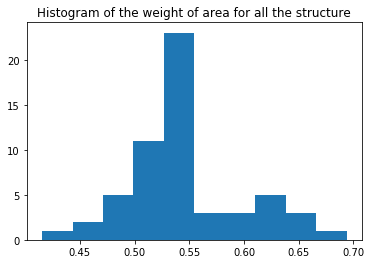

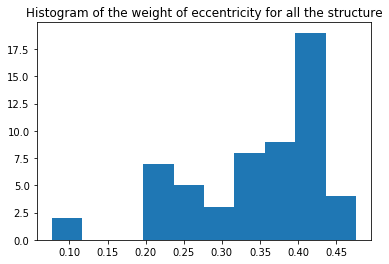

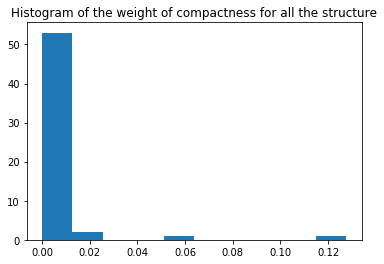

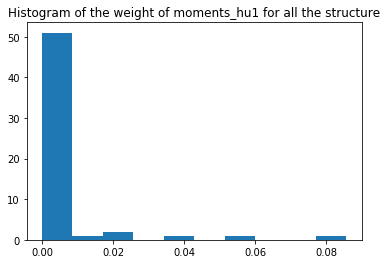

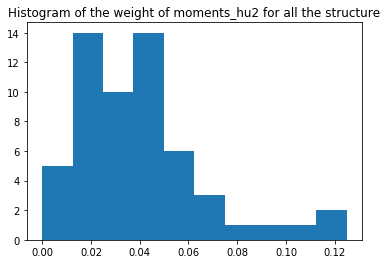

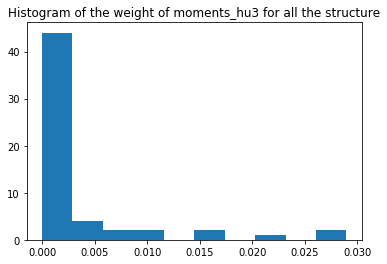

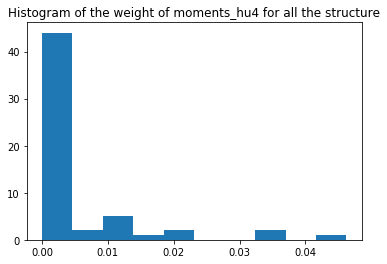

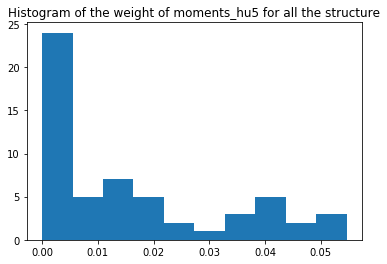

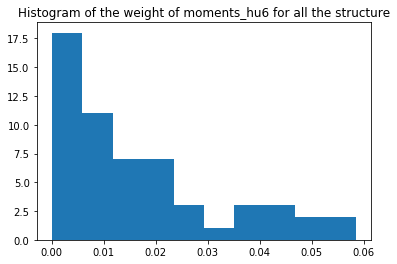

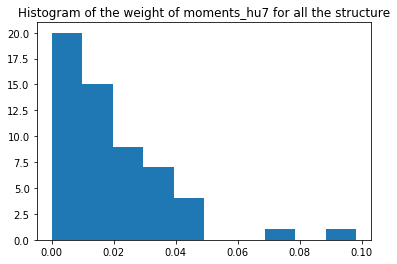

In [16]:
for idx in range(len(learning_features)):
    plt.figure()
    plt.hist(best_weight_flatten[idx]);
    plt.title('Histogram of the weight of %s for all the structure'%learning_features[idx])

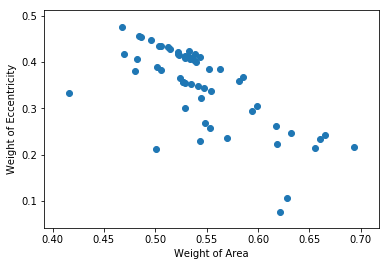

In [17]:
plt.scatter(best_weight_flatten[0], best_weight_flatten[1]);
plt.xlabel('Weight of Area')
plt.ylabel('Weight of Eccentricity')

Does this really mean that weight and area are the most two features for all the structures? Or the algorithms is trying to reproduce the weight we previously set? 

What's the properties of the region that compactness matters?

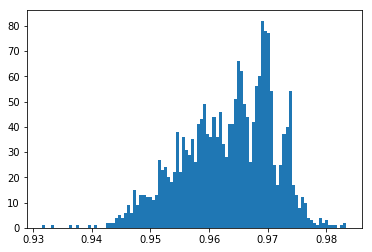

In [18]:
numBins = 100
plt.hist(data_maxSimDiff['7N'],bins=numBins);

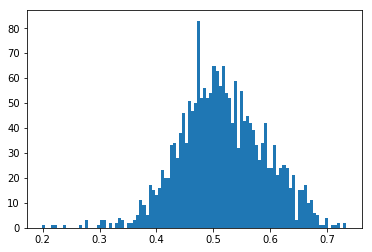

In [29]:
plt.hist(data_weight[load_structure][:,0].flatten(),bins=numBins);